In [59]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Setting the ticker symbols for Infosys Stock
stock_ticker="INFY"

# Collect historical data for Infosys
stock = yf.download(stock_ticker, start="2010-01-01", end="2023-06-01")
print(stock)



[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2010-01-04   7.00250   7.11250   7.00125   7.09500   5.196854  11443200
2010-01-05   7.08750   7.12500   7.04875   7.12250   5.216996   8181600
2010-01-06   7.07250   7.07250   6.97000   7.01375   5.137341  11821600
2010-01-07   6.88500   6.89625   6.77750   6.80000   4.980777  20374400
2010-01-08   6.72125   6.85625   6.69375   6.81750   4.993593  11551200
...              ...       ...       ...       ...        ...       ...
2023-05-24  15.60000  15.64000  15.49000  15.56000  15.352339   6913200
2023-05-25  15.74000  15.76000  15.52000  15.66000  15.451004   9303400
2023-05-26  15.81000  15.94000  15.79000  15.87000  15.658201   6331800
2023-05-30  15.89000  15.95000  15.83000  15.90000  15.687800   6573500
2023-05-31  15.80000  16.01000  15.80000  15.96000  15.747001   904

In [60]:
close_price=stock['Close']

In [61]:
#bollinger band
stock['SMA'] = stock.Close.rolling(20).mean()
AP = (stock.High + stock.Close + stock.Low)/3
SD = AP.rolling(20).std()
stock['upper_bollinger'] = stock['SMA'] + 2*SD
stock['lower_bollinger'] = stock['SMA'] - 2*SD
stock['Signal'] = 'Hold'

In [62]:
stock['Buy_Signal'] = np.where(lower_bollinger > stock.Close ,True,False)
stock['Sell_Signal'] = np.where(upper_bollinger < stock.Close ,True,False)

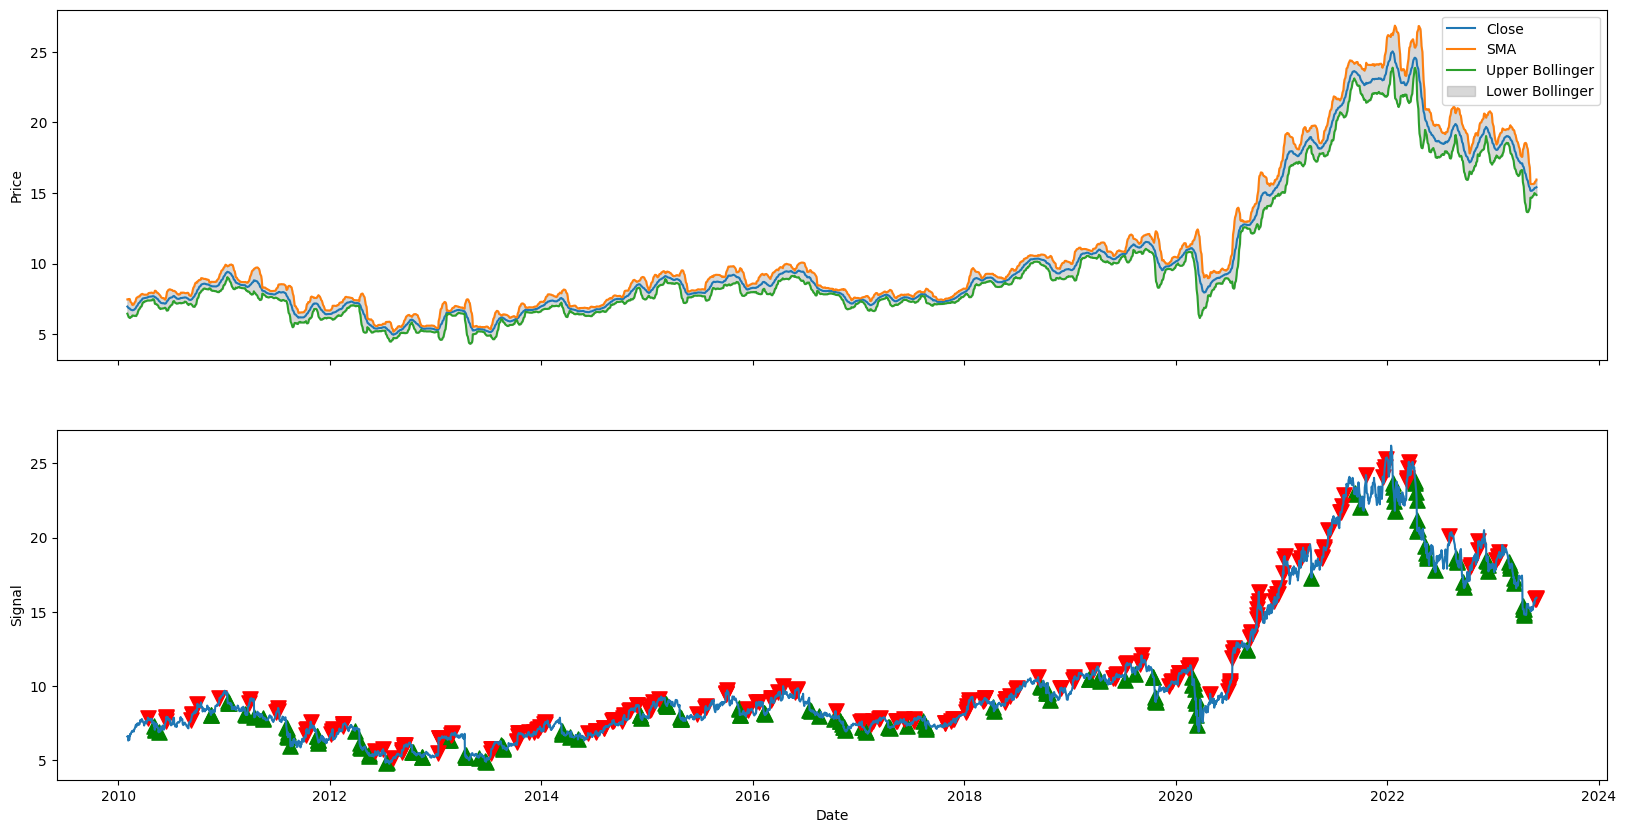

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Plotting the price and Bollinger Bands
ax2.plot(stock['Close'])
ax1.plot(stock['SMA'])
ax1.plot(stock['upper_bollinger'])
ax1.plot(stock['lower_bollinger'])
ax1.fill_between(stock.index, stock['upper_bollinger'], stock['lower_bollinger'], color='grey', alpha=0.3)
ax1.legend(['Close', 'SMA', 'Upper Bollinger', 'Lower Bollinger'])

# Plotting the buy and sell signals
ax2.scatter(stock.index[stock.Buy_Signal], stock.loc[stock.Buy_Signal, 'Close'], marker='^', color='g', s=120)
ax2.scatter(stock.index[stock.Sell_Signal], stock.loc[stock.Sell_Signal, 'Close'], marker='v', color='r', s=120)

# Setting labels and title
ax1.set_ylabel('Price')
ax2.set_ylabel('Signal')
ax2.set_xlabel('Date')

plt.show()

In [64]:
stock['daily_returns'] =(stock['Close']-stock['Open'])/stock['Open']
stock['loc'] = np.where(stock['Buy_Signal'] > stock['Sell_Signal'], stock['daily_returns'], -stock['daily_returns'])
stock_bb_cumulative_return= (stock['loc'] + 1).product() -1

In [65]:
stock['cumulative_rolling_max'] = (stock['loc'] + 1).cumprod()-1
drawdown = stock_bb_cumulative_return - stock['cumulative_rolling_max']
stock_bb_Max_drawdown = np.min(drawdown)

In [66]:
annual_returns= stock['loc'].mean()*252
risk_free_rate = 0.02
annual_std_dev = stock['loc'].std()*np.sqrt(252)
stock_bb_Sharpe_ratio=(annual_returns-risk_free_rate) / annual_std_dev

In [67]:
print("Max Drawdown:",stock_bb_Max_drawdown)
print("Cumulative Return:",stock_bb_cumulative_return)
print("Sharpe Ratio:",stock_bb_Sharpe_ratio)

Max Drawdown: -1.1169692553883057
Cumulative Return: -0.9908051811941739
Sharpe Ratio: -2.005368560783781


In [81]:
def implement_bollinger_strategy(prices, upper_band, lower_band):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = 0

    for i in range(len(prices)):
        if prices[i] < lower_band[i]:
            if position != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                position = 1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif prices[i] > upper_band[i]:
            if position != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                position = -1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    return buy_price, sell_price, bb_signal
buy_price, sell_price, bb_signal = implement_bollinger_strategy(stock['Close'], upper_bollinger, lower_bollinger)

position = []
if bb_signal[0] == 1:
    position.append(1)
else:
    position.append(0)

for i in range(1, len(stock['Close'])):
    if bb_signal[i] == 1:
        position.append(1)
    elif bb_signal[i] == -1:
        position.append(0)
    else:
        position.append(position[i-1])

bb_signal = pd.DataFrame(bb_signal).rename(columns={0: 'bb_signal'}).set_index(stock.index)
position = pd.DataFrame(position).rename(columns={0: 'bb_position'}).set_index(stock.index)

frames = [close_price, upper_bollinger, lower_bollinger, bb_signal, position]
strategy = pd.concat(frames, join='inner', axis=1)
print(strategy)

               Close          0          1  bb_signal  bb_position
Date                                                              
2010-02-01   6.60750   7.455796   6.446704          0            0
2010-02-02   6.63375   7.455461   6.400914          0            0
2010-02-03   6.65000   7.441582   6.367543          0            0
2010-02-04   6.33625   7.449879   6.291496          0            0
2010-02-05   6.36625   7.481293   6.216707          0            0
...              ...        ...        ...        ...          ...
2023-05-24  15.56000  15.662568  14.990432          0            1
2023-05-25  15.66000  15.708219  14.979781          0            1
2023-05-26  15.87000  15.792763  14.928237          0            1
2023-05-30  15.90000  15.872723  14.889277          0            1
2023-05-31  15.96000  15.949135  14.854865          0            1

[3356 rows x 5 columns]


In [69]:
stock_ret = np.diff(stock['Close'])
bb_strategy_ret = []

for i in range(len(stock_ret)):
    try:
        returns = stock_ret[i] * strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass

In [70]:
investment_value = 100000
number_of_stocks = floor(investment_value / stock['Close'][0])
bb_investment_ret = []

for i in range(len(bb_strategy_ret)):
    returns = number_of_stocks * bb_strategy_ret[i]
    bb_investment_ret.append(returns)

total_investment_ret = round(sum(bb_investment_ret), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)

print(cl('Profit gained from the Bollinger Bands strategy by investing 100k in Infosys: {}'.format(total_investment_ret), attrs=['bold']))
print(cl('Profit percentage of the Bollinger Bands strategy: {}%'.format(profit_percentage), attrs=['bold']))

Profit gained from the Bollinger Bands strategy by investing 100k in Infosys: -13882.61
Profit percentage of the Bollinger Bands strategy: -14%


In [71]:
#RSI
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

stock['RSI'] = get_rsi(stock['Close'], 20)
stock = stock.dropna()
stock

,Open,High,Low,Close,Adj Close,Volume,SMA,upper_bollinger,lower_bollinger,Signal,Buy_Signal,Sell_Signal,daily_returns,loc,cumulative_rolling_max,RSI
Date,,,,,,,,,,,,,,,,
2010-02-01,6.52750,6.61375,6.50375,6.60750,4.839775,9820000,6.951250,7.455796,6.446704,Hold,False,False,0.012256,-0.012256,0.099640,44.683689
2010-02-02,6.59875,6.63750,6.51750,6.63375,4.859003,9934400,6.928188,7.455461,6.400914,Hold,False,False,0.005304,-0.005304,0.093807,45.589076
2010-02-03,6.63750,6.67750,6.61375,6.65000,4.870905,13236000,6.904563,7.441582,6.367543,Hold,False,False,0.001883,-0.001883,0.091747,46.163279
2010-02-04,6.54250,6.57500,6.33000,6.33625,4.641094,19711200,6.870688,7.449879,6.291496,Hold,False,False,-0.031525,0.031525,0.126164,38.010795
2010-02-05,6.33000,6.39500,6.19375,6.36625,4.663069,21076000,6.849000,7.481293,6.216707,Hold,False,False,0.005727,-0.005727,0.119715,39.093411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,15.60000,15.64000,15.49000,15.56000,15.352339,6913200,15.326500,15.662568,14.990432,Hold,False,False,-0.002564,0.002564,-0.990717,46.599507
2023-05-25,15.74000,15.76000,15.52000,15.66000,15.451004,9303400,15.344000,15.708219,14.979781,Hold,False,False,-0.005083,0.005083,-0.990670,48.372618
2023-05-26,15.81000,15.94000,15.79000,15.87000,15.658201,6331800,15.360500,15.792763,14.928237,Hold,False,True,0.003795,-0.003795,-0.990705,51.902887


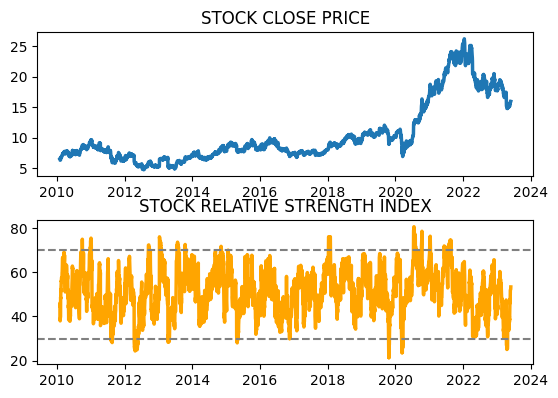

In [72]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(stock['Close'], linewidth = 2.5)
ax1.set_title('STOCK CLOSE PRICE')
ax2.plot(stock['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('STOCK RELATIVE STRENGTH INDEX')
plt.show()

In [73]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(stock['Close'], stock['RSI'])

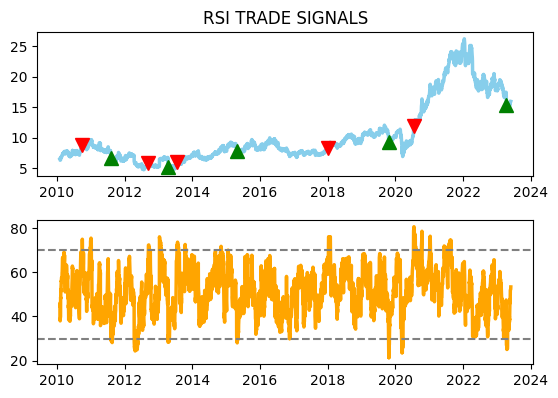

In [74]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(stock['Close'], linewidth = 2.5, color = 'skyblue', label = 'STOCK')
ax1.plot(stock.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(stock.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('RSI TRADE SIGNALS')
ax2.plot(stock['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [75]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stock['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = stock['RSI']
close_price = stock['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(stock.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(stock.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,Close,RSI,rsi_signal,rsi_position
Date,,,,
2010-02-01,6.60750,44.683689,0,1
2010-02-02,6.63375,45.589076,0,1
2010-02-03,6.65000,46.163279,0,1
2010-02-04,6.33625,38.010795,0,1
2010-02-05,6.36625,39.093411,0,1


In [76]:
from termcolor import colored as cl 
from math import floor


Stock_ret = pd.DataFrame(np.diff(stock['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(Stock_ret)):
    returns = Stock_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/stock['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in Infosys : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in Infosys : 38130.36
Profit percentage of the RSI strategy : 38%
